## Business Objective: Created AI Based Machine learning Chatbot for ExcelR

## Step 1: Loading the Required Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Step 2: WordNet is the lexical database i.e. dictionary for the English language, specifically designed for natural language processing.

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Binita
[nltk_data]     Mandal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Step 3: Loading the json file

In [3]:
def load_doc(jsonFile):
    with open(jsonFile) as file:
        Json_data = json.loads(file.read())
    return Json_data

In [4]:
data = load_doc(r"C:\Users\Binita Mandal\Desktop\Email_pro\Chatbot\ChatBot-main\dataset\intents.json")

## Step 4: Framing the json file for smooth transition

In [5]:
def frame_data(feat_1,feat_2,is_pattern):
    is_pattern = is_pattern
    df = pd.DataFrame(columns=[feat_1,feat_2])
    for intent in data['intents']:
        if is_pattern:
            for pattern in intent['patterns']:
                w = pattern
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
        else:
            for response in intent['responses']:
                w = response
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
    return df

## Step 5: Exploratory Data Analysis

In [6]:
# users intents 
df1 = frame_data('questions','labels',True)
df1

questions              labels
0                                            Hi there  start_conversation
1                                    Is anyone there?  start_conversation
2                                                 Hey  start_conversation
3                                                Hola  start_conversation
4                                               Hello  start_conversation
..                                                ...                 ...
84                  What is Pruning in Decision Tree?       Decision_tree
85                 What are the advantage of Pruning?       Decision_tree
86  What is the difference between Entropy and Inf...       Decision_tree
87      Explain the expression of Gain of any column?       Decision_tree
88  What is the package required to implement Deci...       Decision_tree

[89 rows x 2 columns]

In [7]:
# Descriptive analysis

df1.labels.value_counts(sort=False)

end_conversation       5
bot_scope              5
function               7
Naive_Bayes            2
options                8
thanks                 5
Z_transformation       3
normalization          8
Clustering             8
KNN                    4
SVM                   10
probability            2
what_are_you           4
Decision_tree          9
distribution           2
start_conversation     7
Name: labels, dtype: int64

In [8]:
# Bot response

df2 = frame_data('response','labels',False)
df2.head()

response              labels
0  Hello, I'm sure you are interested in Data Sci...  start_conversation
1                             Happy to have you here  start_conversation
2                              Good to see you again  start_conversation
3                          Hi there, how can I help?  start_conversation
4                                Hi, I'm  DS Chatbot        what_are_you

## Step 6: Lemmatization with NLTK

      Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

In [9]:
lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

## Step 7: Removing stop words with NLTK
    Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. 

In [10]:
def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return 

## Step 8: Tokenize text using NLTK

       NLTK contains a module called tokenize() which further classifies into two sub-categories: Word tokenize: We use the word_tokenize() method to split a sentence into tokens or words. Sentence tokenize: We use the sent_tokenize() method to split a document or paragraph into sentences.

In [11]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)   
        vocab.update(tokens)
    joblib.dump(vocab,'vocab.pkl')
    return 

In [12]:
create_vocab(tokenizer,df1,'questions')
remove_stop_words(tokenizer,df1,'questions')

In [13]:
print(vocab.most_common(20))

[('what', 45), ('is', 32), ('you', 24), ('in', 18), ('do', 17), ('the', 15), ('of', 15), ('are', 10), ('svm', 10), ('how', 8), ('by', 8), ('clustering', 8), ('to', 7), ('data', 7), ('mean', 7), ('decision', 6), ('tree', 6), ('can', 5), ('about', 5), ('science', 5)]


In [14]:
vocab_size = len(vocab)
vocab_size

170

In [15]:
# Exporing the dataframe

df1

questions              labels
0                                            hi there  start_conversation
1                                     is anyone there  start_conversation
2                                                 hey  start_conversation
3                                                hola  start_conversation
4                                               hello  start_conversation
..                                                ...                 ...
84                   what is pruning in decision tree       Decision_tree
85                  what are the advantage of pruning       Decision_tree
86  what is the difference between entropy and inf...       Decision_tree
87       explain the expression of gain of any column       Decision_tree
88  what is the package required to implement deci...       Decision_tree

[89 rows x 2 columns]

## Step 9: Model Building

In [16]:
test_list = list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list

['why is hierarchial clustering called agglomerative clustering',
 'what is decision tree',
 'why is knn called nonparametric algorithm',
 'what is bayes theorem',
 'what is svm',
 'what is the range of transformed variable',
 'what do you know about data science',
 'what do you mean by degree of freedom',
 'bye',
 'what do you mean by hypothesis testing',
 'what is the range of variable when normalization technique is employed',
 'how can you help me',
 'what is probability',
 'hi there',
 'thanks',
 'what is your name']

In [17]:
test_index = []
for i,_ in enumerate(test_list):
    idx = df1[df1.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index

[44, 80, 72, 78, 34, 52, 29, 63, 11, 65, 55, 21, 76, 0, 16, 7]

In [18]:
train_index = [i for i in df1.index if i not in test_index]

In [19]:
' '.join(list(vocab.keys()))

'hi there is anyone hey hola hello good day what your name are you who pls bye see later goodbye nice chatting to till next time thanks thank thats helpful awesome for helping me how can help do provide be support offered know about data science tell really lot exactly mean by guide through svm the tuning parameter of explain kernel in need convert categorical variable into numeric if yes regularization gamma margin package used function implement hinge loss why hierarchial clustering called agglomerative when say that resultant cluster which domain we employ example normalization required before applying linkage decide upon number interpret output range transformed roc ztransform any signal cannot contain pole true or false transformation technique employed dummy heteroscedasticity multicollinearity test understand use degree freedom go distribution hypothesis testing null curve work naive bayes so prior probability difference between covariance and correlation knn nonparametric algor

In [20]:
def encoder(df,feature):
#     text = ' '.join(list(vocab.keys()))
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    t.fit_on_texts(entries)
    joblib.dump(t,'tokenizer_t.pkl')
    vocab_size = len(t.word_index) + 1
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    encoded = t.texts_to_sequences(entries)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded, vocab_size

In [21]:
X,vocab_size = encoder(df1,'questions')

In [22]:
df_encoded = pd.DataFrame(X)

In [23]:
df_encoded['labels'] = df1.labels
df_encoded.head()

0   1   2  3  4  5  6  7  8  9  10  11  12  13              labels
0  45  30   0  0  0  0  0  0  0  0   0   0   0   0  start_conversation
1   2  66  30  0  0  0  0  0  0  0   0   0   0   0  start_conversation
2  67   0   0  0  0  0  0  0  0  0   0   0   0   0  start_conversation
3  68   0   0  0  0  0  0  0  0  0   0   0   0   0  start_conversation
4  69   0   0  0  0  0  0  0  0  0   0   0   0   0  start_conversation

In [24]:
for i in range(0,2):
    dt = [0]*14
    dt.append('confused')
    dt = [dt]
    pd.DataFrame(dt).rename(columns = {14:'labels'})
    df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {14:'labels'}),ignore_index=True)

In [25]:
df_encoded.tail()

0  1    2   3   4    5   6    7   8  9  10  11  12  13         labels
86   1  2    6  42  43  167  28  168  65  0   0   0   0   0  Decision_tree
87  21  6  169   7  65    7  60  170   0  0   0   0   0   0  Decision_tree
88   1  2    6  51  57   13  53   16  17  4   0   0   0   0  Decision_tree
89   0  0    0   0   0    0   0    0   0  0   0   0   0   0       confused
90   0  0    0   0   0    0   0    0   0  0   0   0   0   0       confused

In [26]:
train_index.append(89)

In [27]:
test_index.append(90)

In [28]:
# df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {16:'labels'}),ignore_index=True)

In [29]:
from sklearn.preprocessing import LabelEncoder
lable_enc = LabelEncoder()

In [30]:
labl = lable_enc.fit_transform(df_encoded.labels)
labl

array([14, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16,  9,  9,  9,  9,  9, 15,
       15, 15, 15, 15, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,  6,  6,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,
        0,  5,  5,  5, 11, 11, 11, 11, 11, 11, 11, 11,  8,  8, 10, 10, 10,
       10, 10, 10, 10,  2,  2,  2,  2, 13, 13,  3,  3,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  7,  7])

In [31]:
mapper = {}
for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'start_conversation': 14,
 'what_are_you': 16,
 'end_conversation': 9,
 'thanks': 15,
 'options': 12,
 'bot_scope': 6,
 'SVM': 4,
 'Clustering': 0,
 'Z_transformation': 5,
 'normalization': 11,
 'distribution': 8,
 'function': 10,
 'KNN': 2,
 'probability': 13,
 'Naive_Bayes': 3,
 'Decision_tree': 1,
 'confused': 7}

In [32]:
df2.head()

response              labels
0  Hello, I'm sure you are interested in Data Sci...  start_conversation
1                             Happy to have you here  start_conversation
2                              Good to see you again  start_conversation
3                          Hi there, how can I help?  start_conversation
4                                Hi, I'm  DS Chatbot        what_are_you

In [33]:
df2.labels = df2.labels.map(mapper).astype({'labels': 'int32'})
df2.head()

response  labels
0  Hello, I'm sure you are interested in Data Sci...      14
1                             Happy to have you here      14
2                              Good to see you again      14
3                          Hi there, how can I help?      14
4                                Hi, I'm  DS Chatbot      16

In [34]:
df2.to_csv('response.csv',index=False)

In [35]:
# df2.groupby('labels').get_group(11)

In [36]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]

In [37]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels


In [38]:
y_train =pd.get_dummies(y_train).values
y_test =pd.get_dummies(y_test).values

In [39]:
y_train[0].shape,y_test[0].shape

((17,), (17,))

In [40]:
X_train.shape

(74, 14)

In [41]:
max_length = X_train.shape[1]
# output = len(df3.labels.unique())
output = 17

In [42]:
# def define_model(vocab_size, max_length):
#     model = Sequential()
#     model.add(Embedding(vocab_size,300, input_length=max_length))
#     model.add(Conv1D(filters=64, kernel_size=6, activation='relu'))
#     model.add(MaxPooling1D(pool_size=4))
#     model.add(Flatten())
# #     model.add(Dense(32, activation='relu'))
#     model.add(Dense(16, activation='softmax'))
    
#     # compile network
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     # summarize defined model
#     model.summary()
# #     plot_model(model, to_file='model.png', show_shapes=True)
#     return model

In [43]:
max_length

14

In [44]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)
callbacks = [early_stopping,checkpoint,reduce_lr]
    
    

In [45]:

def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size,300, input_length=max_length))
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=8))
    model.add(Flatten())
#     model.add(Dense(32, activation='relu'))
    model.add(Dense(17, activation='softmax'))
    
    
    # compile network
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss = 'categorical_crossentropy',
              # optimizer = Adam(lr=0.001),
              optimizer = 'adam',
              metrics = ['accuracy'])
    
    # summarize defined model
    model.summary()
#     plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [46]:
# define model
model = define_model(vocab_size, max_length)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 300)           51300     
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 64)            76864     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 17)                1105      
Total params: 129,269
Trainable params: 129,269
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(X_train, y_train, epochs=500, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/500
1/3 [=========>....................] - ETA: 0s - loss: 2.8256 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 2.81553, saving model to model-v1.h5
3/3 [==============================] - 1s 168ms/step - loss: 2.8250 - accuracy: 0.0676 - val_loss: 2.8155 - val_accuracy: 0.1176
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 2.7273 - accuracy: 0.2812
Epoch 00002: val_loss improved from 2.81553 to 2.79956, saving model to model-v1.h5
3/3 [==============================] - 0s 38ms/step - loss: 2.7017 - accuracy: 0.3649 - val_loss: 2.7996 - val_accuracy: 0.2353
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 2.6135 - accuracy: 0.5625
Epoch 00003: val_loss improved from 2.79956 to 2.78308, saving model to model-v1.h5
3/3 [==============================] - 0s 32ms/step - loss: 2.6118 - accuracy: 0.5811 - val_loss: 2.7831 - val_accuracy: 0.2353
Epoch 4/500
1/3 [=========>....................] - ETA: 0s - loss: 2.5234 - accuracy

Epoch 28/500
1/3 [=========>....................] - ETA: 0s - loss: 0.5012 - accuracy: 1.0000
Epoch 00028: val_loss improved from 1.99823 to 1.96073, saving model to model-v1.h5
3/3 [==============================] - 0s 36ms/step - loss: 0.4382 - accuracy: 0.9730 - val_loss: 1.9607 - val_accuracy: 0.5294
Epoch 29/500
1/3 [=========>....................] - ETA: 0s - loss: 0.3652 - accuracy: 1.0000
Epoch 00029: val_loss improved from 1.96073 to 1.91451, saving model to model-v1.h5
3/3 [==============================] - 0s 36ms/step - loss: 0.3915 - accuracy: 0.9730 - val_loss: 1.9145 - val_accuracy: 0.5294
Epoch 30/500
1/3 [=========>....................] - ETA: 0s - loss: 0.4637 - accuracy: 0.9375
Epoch 00030: val_loss improved from 1.91451 to 1.87373, saving model to model-v1.h5
3/3 [==============================] - 0s 32ms/step - loss: 0.3527 - accuracy: 0.9730 - val_loss: 1.8737 - val_accuracy: 0.5294
Epoch 31/500
1/3 [=========>....................] - ETA: 0s - loss: 0.4019 - accur

Epoch 55/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1027 - accuracy: 0.9688
Epoch 00055: val_loss improved from 1.42339 to 1.41890, saving model to model-v1.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0634 - accuracy: 0.9865 - val_loss: 1.4189 - val_accuracy: 0.6471
Epoch 56/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0969 - accuracy: 0.9688
Epoch 00056: val_loss improved from 1.41890 to 1.41437, saving model to model-v1.h5
3/3 [==============================] - 0s 35ms/step - loss: 0.0605 - accuracy: 0.9865 - val_loss: 1.4144 - val_accuracy: 0.6471
Epoch 57/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0335 - accuracy: 1.0000
Epoch 00057: val_loss improved from 1.41437 to 1.41019, saving model to model-v1.h5
3/3 [==============================] - 0s 36ms/step - loss: 0.0576 - accuracy: 0.9865 - val_loss: 1.4102 - val_accuracy: 0.6471
Epoch 58/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0918 - accur

Epoch 82/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0342 - accuracy: 1.0000
Epoch 00082: val_loss improved from 1.35277 to 1.35202, saving model to model-v1.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 1.3520 - val_accuracy: 0.7059
Epoch 83/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - accuracy: 1.0000
Epoch 00083: val_loss improved from 1.35202 to 1.35141, saving model to model-v1.h5
3/3 [==============================] - 0s 37ms/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 1.3514 - val_accuracy: 0.7059
Epoch 84/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - accuracy: 1.0000
Epoch 00084: val_loss improved from 1.35141 to 1.35002, saving model to model-v1.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 1.3500 - val_accuracy: 0.6471
Epoch 85/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - accur

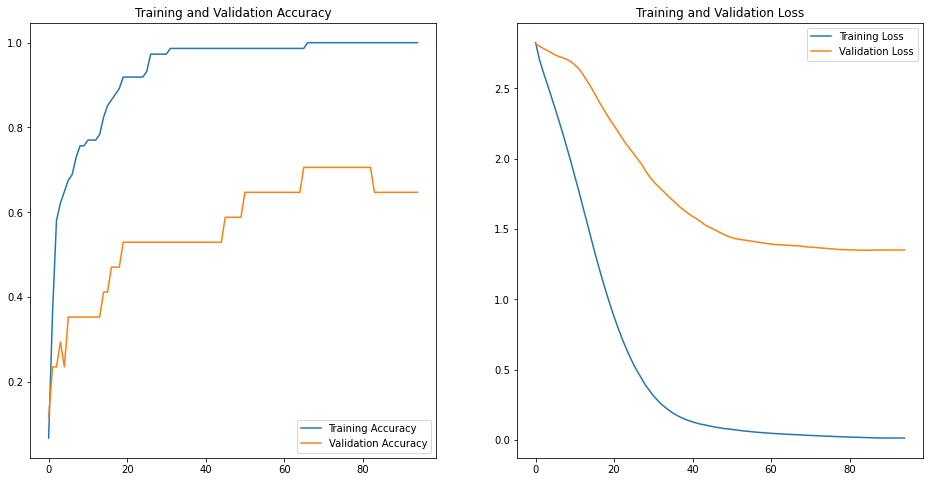

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
[np.argmax(i) for i in model.predict(X_test)][:10]

[0, 1, 2, 10, 4, 1, 6, 5, 7, 10]

In [50]:
[np.argmax(i) for i in y_test][:10]

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10]

## New user question encoding

In [51]:
def get_text():
    input_text  = ['what are you']
    df_input = pd.DataFrame(input_text,columns=['questions'])
    df_input
    return df_input 

In [52]:
#load artifacts 
from tensorflow.keras.models import load_model
model = load_model('model-v1.h5')
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

In [53]:
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [54]:
def remove_stop_words_for_input(tokenizer,df,feature):
    doc_without_stopwords = []
    entry = df[feature][0]
    tokens = tokenizer(entry)
    doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return df

In [55]:
# df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
# df_input

In [56]:
def encode_input_text(tokenizer_t,df,feature):
    t = tokenizer_t
    entry = entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=16, padding='post')
    return padded

In [57]:
# encoded_input = encode_input_text(tokenizer_t,df_input,'questions')
# encoded_input.shape

In [58]:
# encoded_input

In [59]:
def get_pred(model,encoded_input):
    pred = np.argmax(model.predict(encoded_input))
    return pred

In [60]:
# mapper

In [61]:
# df2.head()

In [62]:
def bot_precausion(df_input,pred):
    words = df_input.questions[0].split()
    if len([w for w in words if w in vocab])==0 :
        pred = 1
    return pred

In [63]:
def get_response(df2,pred):
    upper_bound = df2.groupby('labels').get_group(pred).shape[0]
    r = np.random.randint(0,upper_bound)
    responses = list(df2.groupby('labels').get_group(pred).response)
    return responses[r]
    

In [64]:
def bot_response(response,):
    print(response)

In [65]:
df_input = get_text()

#load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)

Call me ChatBot
